In [1]:
using LinearAlgebra
function solve_trust_region_subproblem(Bk, g, delta, lam0=-1)
#A pedagogical solver for the trust region subproblem
n = size(Bk, 1)

okay, R, p, q = getchol(Bk, 0, g)
if okay
    if norm(p) < delta
        lam = 0
        return p, lam
    end
end

if lam0 > 0
    lam = lam0
else
    lam = 1
end
first = true
oldlam = lam

for i = 1:100 # maxiter should be an option
    @assert lam > 0
    okay, ~, p, q = getchol(Bk, lam, g)
    if !okay && !first
        #then lam is too small, bisect back to oldlam, which was good
        lam = lam + (oldlam - lam)/2;
        continue
    elseif first && !okay
        #keep increasing until we get somewhere
        found = false
        for j = 1:20 #maxfinditer should be an option
            lam = 2*lam
            okay, ~, p, q = getchol(Bk, lam, g)
            if okay
                found = true
                break
            end
        end
        @assert found
    end
    first = false
    if abs(norm(p) - delta) < 1e-6 #tol should be an option
        return p, lam
    end

    oldlam = lam
    lam = lam + (norm(p)/norm(q))^2 * (norm(p)-delta)/delta
end
error("too many iterations")
end

function getchol(Bk, lam, g)
n = size(Bk, 1)
try
    F = cholesky(Bk + lam*I)
    R = F.U
    p1 = R'\(-g)
    p = R\p1
    q = R'\p
    okay = true
    return okay, R, p, q                
catch e
    okay = false
    R = []
    p = []
    q = []
    return okay, R, p, q
end
end
getchol([1.0 0; 0 1.0], 1.0, [2.0,2.0])
getchol([-2.0 0; 0 1.0], 1.0, [2.0,2.0])
getchol([-2.0 0; 0 1.0], 3.0, [2.0,2.0])

(true, [1.0 0.0; 0.0 2.0], [-2.0, -0.5], [-2.0, -0.25])

In [2]:
using OptimTestProblems
# These codes turn f and g and H into one function ... 
function opt_combine(x, f, g!, h!)
    g = Array{Float64,1}(undef,length(x))
    g!(g,x)
    H = Array{Float64,2}(undef,length(x),length(x))
    h!(H,x)
    return (f(x), g, H)
end
function opt_problem(p::OptimTestProblems.UnconstrainedProblems.OptimizationProblem)
    return x -> opt_combine(x, p.f, p.g!, p.h!), p
end
# this just makes it easy to use
opt_problem(s::AbstractString) = opt_problem(
    OptimTestProblems.UnconstrainedProblems.examples[s])

# Here's an example 
fgH, p = opt_problem("Rosenbrock")
f, g, H = fgH([0.0,0.0]) # show the function, gradient, and Hessian
p.f([0.0,0.0]) # get the function 

1.0

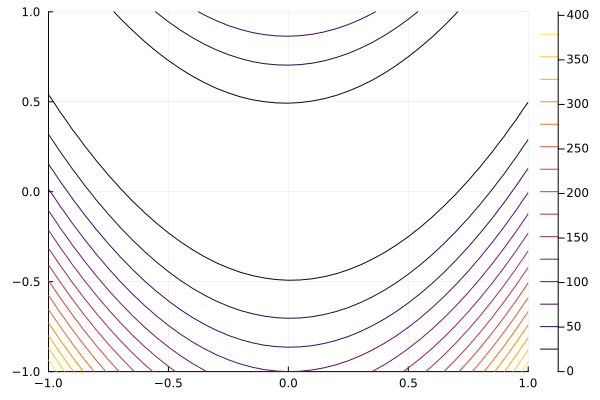

In [11]:
using Plots
ezcontour(x, y, f) = begin
    X = repeat(x', length(y), 1)
    Y = repeat(y, 1, length(x))
    # Evaluate each f(x, y)
    Z = map((x,y) -> f([x,y]), X, Y)
    plot(x, y, Z, st=:contour)
end
ezcontour(-1:0.05:1, -1:0.05:1, 
   opt_problem("Rosenbrock")[2].f)

## Show an example with the Rosenbrock function

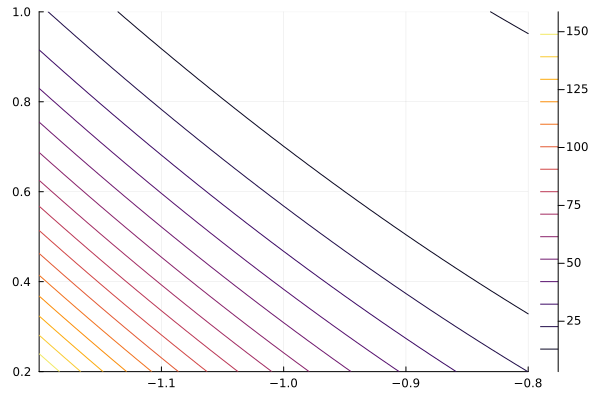

In [12]:
# show an example with the Rosenbrock function
x0 = [-1.0,0.5]
rx = -1.2:0.01:-0.8
ry = 0.2:0.01:1
fgH, p = opt_problem("Rosenbrock")
ezcontour(rx,ry,p.f)

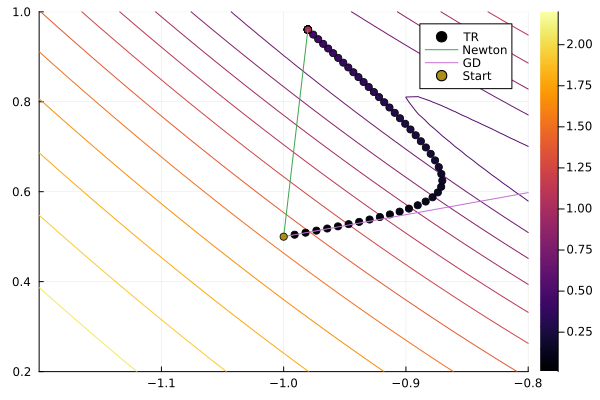

In [13]:
deltas = 0.01:0.01:1
f0,g,H = fgH(x0)
ps = map(d -> solve_trust_region_subproblem(H,g,d)[1], deltas)
ezcontour(rx,ry,x -> log10.(p.f(x)))
scatter!(map(first, ps).+x0[1], map(x->x[2], ps).+x0[2], 
        marker_z = deltas,  label="TR")
newton = -H\g
plot!([x0[1],x0[1] + newton[1]], [x0[2],x0[2]+newton[2]], label="Newton")
plot!([x0[1],x0[1] - g[1]], [x0[2],x0[2]-g[2]], label="GD")
scatter!([x0[1]], [x0[2]], label="Start")
xlims!(rx[1],rx[end])
ylims!(ry[1],ry[end])

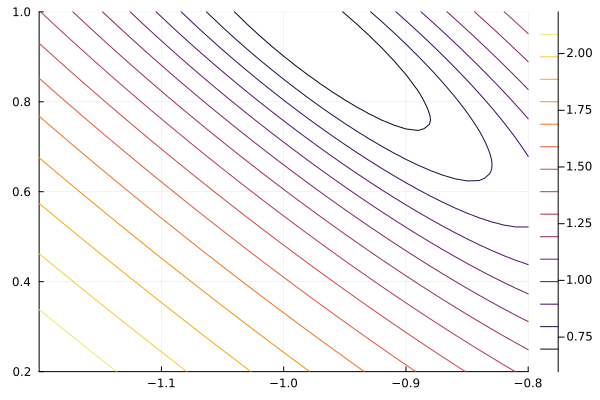

In [6]:
## Show the contours of the Trust region function
trmodel(x) = f0 .+ (x.-x0)'*g .+ 1.0/2.0*(x.-x0)'*H*(x.-x0)
ezcontour(rx,ry,x -> log10.(trmodel(x)))

In [ ]:
## Show the Cauchy point as Delta varies
ps = map(d -> -g/norm(g).*d.*min.(norm(g)^3.0./(d.*g'*H*g),d), deltas)
scatter!(map(first, ps).+x0[1], map(x->x[2], ps).+x0[2], 
        marker_z = deltas,  label="TR")

In [ ]:
(-g'*g ./ (g'*H*g)).*g

In [7]:
using Pkg; Pkg.add("Polynomials")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


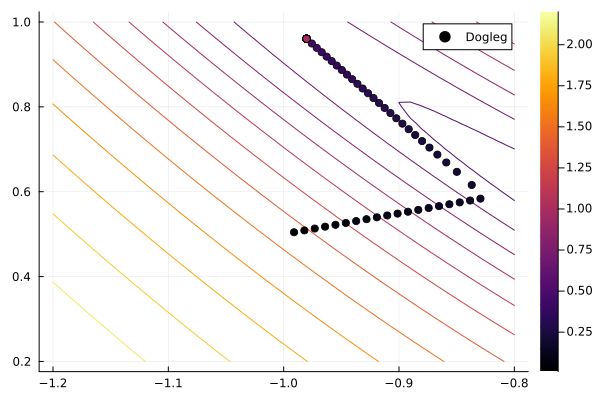

In [14]:
using Polynomials
function dogleg(delta,H,g)
    pfull = -H\g 
    pu = (-g'*g ./ (g'*H*g)).*g
    pdiff = pfull .- pu
    if norm(pfull) < delta
        return pfull
    elseif norm(pu) > delta
        return pu/norm(pu)*delta 
    else # find the intersection with the dogleg path
        # test 
        tmin = roots(ImmutablePolynomial([pu'*pu - delta*delta,2*pdiff'*pu,pdiff'*pdiff]))
        filter!(x -> x >= 0 && x <= 1, tmin)                
        @assert length(tmin) == 1
        tmin1 = tmin[1]
        return pu + (tmin1)*pdiff        
    end            
end

ps = map(d -> dogleg(d,H,g), deltas)
ezcontour(rx,ry,x -> log10.(p.f(x)))        
scatter!(map(first, ps).+x0[1], map(x->x[2], ps).+x0[2], 
        marker_z = deltas,  label="Dogleg")

## Try on a crazier function

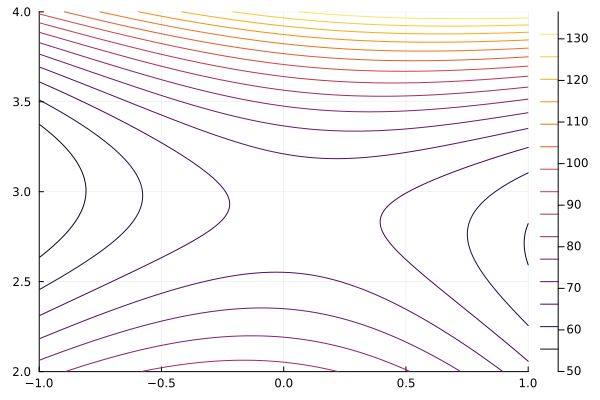

In [15]:
x0 = [0,3.6]
rx = -1:0.01:1
ry = 2:0.01:4
fgH, p = opt_problem("Himmelblau")
ezcontour(rx,ry,p.f)

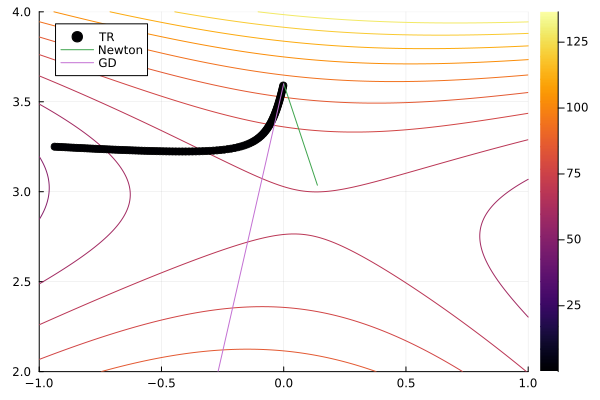

In [16]:
deltas = 0.01:0.01:1
f0,g,H = fgH(x0)
ps = map(d -> solve_trust_region_subproblem(H,g,d)[1], deltas)
ezcontour(rx,ry,x -> (p.f(x)))
scatter!(map(first, ps).+x0[1], map(x->x[2], ps).+x0[2], 
        marker_z = deltas,  label="TR")
newton = -H\g
plot!([x0[1],x0[1] + newton[1]], [x0[2],x0[2]+newton[2]], label="Newton")
plot!([x0[1],x0[1] - g[1]], [x0[2],x0[2]-g[2]], label="GD")
xlims!(rx[1],rx[end])
ylims!(ry[1],ry[end])

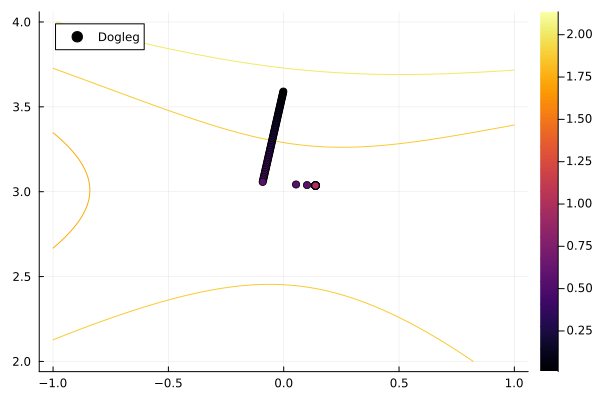

In [17]:
using Polynomials
function dogleg(delta,H,g)
    pfull = -H\g 
    pu = (-g'*g ./ (g'*H*g)).*g
    pdiff = pfull .- pu
    #println(norm(pfull))
    #println(norm(pu))
    if norm(pfull) < delta
        return pfull
    elseif norm(pu) > delta
        return (pu/norm(pu))*delta 
    else # find the intersection with the dogleg path
        # test 
        tmin = roots(ImmutablePolynomial([pu'*pu - delta*delta,2*pdiff'*pu,pdiff'*pdiff]))
        filter!(x -> x >= 0 && x <= 1, tmin)                
        @assert length(tmin) == 1
        tmin1 = tmin[1]
        return pu .+ (tmin1)*pdiff        
    end            
end

ps = map(d -> dogleg(d,H,g), deltas)
ezcontour(rx,ry,x -> log10.(p.f(x)))
scatter!(map(first, ps).+x0[1], map(x->x[2], ps).+x0[2], 
        marker_z = deltas,  label="Dogleg")